In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from torchvision import models
from torchvision import transforms
import os

In [3]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning" or os.path.split(os.getcwd())[1] == "semi-supervised" or os.path.split(os.getcwd())[1] == "self-supervised" or os.path.split(os.getcwd())[1] == "misc"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

Current Working Directory: progettoVIPM


In [4]:
cuda=True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [67]:
from utils.loadersAndEnums import datasets, ImageDataset
from torch.utils.data import DataLoader, ConcatDataset, random_split

val = ImageDataset(datasets.VALIDATION_20)
val = DataLoader(val, batch_size=1, shuffle=False)

In [139]:
from torchvision.transforms import v2
class ToFloat32:
    def __call__(self, image):
        return image.float() / 255.0

class ToInt8:
    def __call__(self, image):
        return (image * 255.0).clamp(0, 255).byte()

class AverageBlur:
    def __init__(self, kernel_size=(9, 9)):
        self.kernel_size = kernel_size

    def __call__(self, image):
        if image.dim() == 4:  # If it's a batch of images
            return torch.stack([self._apply_blur(img) for img in image])
        elif image.dim() == 3:  # If it's a single image
            return self._apply_blur(image)
        else:
            raise ValueError(f"Unsupported image dimensions: {image.dim()}")

    def _apply_blur(self, img):
        # Convert the image (Tensor) to a NumPy array and ensure it's in HWC format
        img_np = img.permute(1, 2, 0).numpy()  # Convert CHW to HWC
        # Apply OpenCV's average blur
        blurred_np = cv2.blur(img_np, self.kernel_size)
        # Convert back to a Tensor in CHW format
        return torch.from_numpy(blurred_np).permute(2, 0, 1)  # Convert HWC to CHW

# Replace GaussianBlur with AverageBlur
f32Transform = v2.RandomApply([
    AverageBlur(kernel_size=(9, 9)),  # Custom AverageBlur
    v2.GaussianNoise(0, 0.25)
])

i8Transform = v2.RandomApply([
    v2.RandomPosterize(2, 1),
    v2.JPEG([20, 50])
])

augment = v2.Compose([
    f32Transform,
    ToInt8(),
    i8Transform,
    ToFloat32()
])

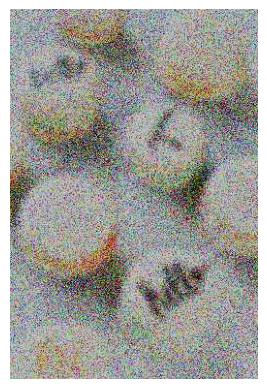

In [176]:
batch = next(iter(val))
image, label = batch
image = augment(image)
def show_image(image):
    """
    Function to display an image using matplotlib.pyplot
    :param image: Input image (numpy array or torch tensor)
    """
    if isinstance(image, torch.Tensor):
        image = image.squeeze(0).cpu().numpy()  # Remove batch dimension and convert to numpy array
    plt.imshow(np.transpose(image, (1, 2, 0)))  # Transpose to (height, width, channels)
    plt.axis('off')
    plt.show()
show_image(image)


In [175]:

csv_file = 'validation_set_20%.csv'
df = pd.read_csv(csv_file, header=None)
df = df[0]
image_names = df.to_list()

output_dir = 'val_20_augmented'
os.makedirs(output_dir, exist_ok=True)

for idx, (image, label) in enumerate(val):
    augmented_image = augment(image)
    image_name = image_names[idx]
    output_path = os.path.join(output_dir, f"{image_name}")
    
    augmented_image_np = augmented_image.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255
    augmented_image_np = cv2.cvtColor(augmented_image_np.astype(np.uint8), cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, augmented_image_np)

In [13]:
from utils.loadersAndEnums import datasets, ImageDataset
from torch.utils.data import DataLoader, ConcatDataset, random_split

val = ImageDataset(datasets.VALIDATION_20_DEGRADED)
val = DataLoader(val, batch_size=1, shuffle=True)

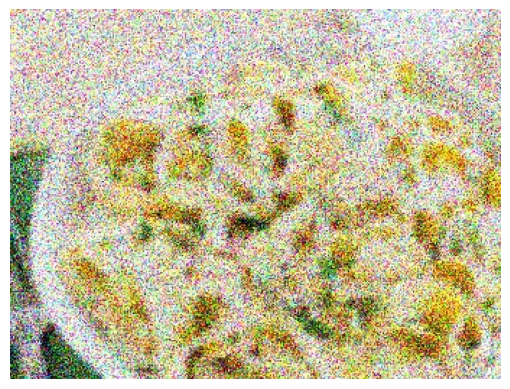

In [65]:
batch = next(iter(val))
image, label = batch
def show_image(image):
    """
    Function to display an image using matplotlib.pyplot
    :param image: Input image (numpy array or torch tensor)
    """
    if isinstance(image, torch.Tensor):
        image = image.squeeze(0).cpu().numpy()  # Remove batch dimension and convert to numpy array
    plt.imshow(np.transpose(image, (1, 2, 0)))  # Transpose to (height, width, channels)
    plt.axis('off')
    plt.show()
show_image(image)